In [1]:
import pandas as pd
from tqdm import tqdm

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

## Load data

In [123]:
base = 'COMP'
quote = 'BTC'

folder_path = 'data_loader/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'quotes']

tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'trades']

ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'quotes']

utfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'trades']

In [124]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [125]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

upbit_trades_data = get_data(utfiles_list)
binance_trades_data = get_data(tfiles_list)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 140.33it/s]


In [127]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_trades_lst =  upbit_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()

In [159]:
symbol = base + quote

hedging = TOB_Exchange(latency=[5000, 0.29])
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 0.2)
hedging.add_balance(quote, 10_000)
hedging.load_tob(binance_lst, symbol)
hedging.load_trades(binance_trades_lst, symbol)

In [160]:
origin = TOB_Exchange(latency=[5000, 0.29])
origin.add_market(symbol, base, quote)
origin.add_balance(base, 0.2)
origin.add_balance(quote, 10_000)
origin.load_tob(upbit_lst, symbol)
origin.load_trades(upbit_trades_lst, symbol)

In [161]:
class cross_exchange(): 
    def __init__(self):
        self.base = 'COMP'
        self.quote = 'BTC'
        self.symbol = self.base + self.quote
        self.amount = 10

        self.distance = 100 / 10_000 # place orders at 10bps distance
        self.sensitivity =  50 / 10_000 # after a move of 4bps, replace the order

        self.last_trade = None

        self.timestamp = None

        self.current_bid = None 
        self.current_ask = None

        self.hedging_ask = None 
        self.hedging_bid = None

        self.bid_open = None 
        self.ask_open = None


        self.initial_sell = False
        self.initial_buy = False

        self.counter = 0
        self.balances = []

    def run_strategy(self):

        hedging_tob = hedging.fetch_tob(self.symbol)
        origin_tob = origin.fetch_tob(self.symbol)
        self.current_ask = origin_tob['ask_price']
        self.current_bid = origin_tob['bid_price']
        self.hedging_ask = hedging_tob['ask_price']
        self.hedging_bid = hedging_tob['bid_price']

        self.timestamp = max(origin_tob['timestamp'], hedging_tob['timestamp'])

        # If a trade was executed on the origin, make a market order on the hedging exchange
        if len(origin.trades) > 0: 
            if origin.trades[-1] != self.last_trade:
                self.last_trade = origin.trades[-1]

                if self.last_trade.side: 
                    side = 0 
                    self.initial_buy = False

                else: 
                    side = 1
                    self.initial_sell = False

                print('hedging')
                hedging.market_order(self.symbol, self.amount, side, self.timestamp)

        # Open orders if they currently arent open
        if len(origin.open_orders[self.symbol][0]) == 0 and not self.initial_sell: 
            new_price = round(self.hedging_ask * (1 + self.distance), 8)
            print(f'Sell {self.amount} @ {new_price} with {self.hedging_ask}')
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.ask_open = self.hedging_ask
            self.initial_sell = True

        # if the price moved too much, replace the order
        elif (abs(self.ask_open / self.hedging_ask) - 1 > self.sensitivity) and (len(origin.open_orders[self.symbol][0]) > 0): 
            new_price = round(self.hedging_ask * (1 + self.distance), 8)
            print(f'Replacing sell {self.amount} @ {new_price} with {self.hedging_ask}')
            origin.cancel_order(origin.open_orders[self.symbol][0].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.ask_open = self.hedging_ask

        if len(origin.open_orders[self.symbol][1]) == 0 and not self.initial_buy: 
            new_price = round(self.hedging_ask * (1 - self.distance), 8)
            print(f'Buy {self.amount} @ {new_price} with {self.hedging_bid}')
            origin.limit_order(
                self.symbol, self.amount, new_price, 1, self.timestamp
            )
            self.bid_open = self.hedging_bid
            self.initial_buy = True

        # if the price moved too much, replace the order
        elif (abs(self.bid_open / self.hedging_ask) - 1 > self.sensitivity) and (len(origin.open_orders[self.symbol][1]) > 0): 
            new_price = round(self.hedging_ask * (1 - self.distance), 8)
            print(f'Replacing buy {self.amount} @ {new_price} with {self.hedging_bid}')
            origin.cancel_order(origin.open_orders[self.symbol][1].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, new_price, 0, self.timestamp
            )
            self.bid_open = self.hedging_bid


        # Run the simulation step in the place where we are behind
        if hedging_tob['timestamp'] > origin_tob['timestamp']: 
            origin._simulation_step()
        else: 
            hedging._simulation_step()

    def run_simulation(self):
        while (len(origin.events) > 0) and (len(hedging.events) > 0): 
            self.run_strategy()

            self.counter += 1
            if self.counter % 100:
                update = origin.balance.copy()
                u_2 = hedging.balance.copy()

                update['base_hedging'] = u_2[self.base]
                update['quote_hedging'] = u_2[self.quote]
                update["mid"] = (
                    self.hedging_ask + self.hedging_bid
                ) / 2
                update["ts"] = self.timestamp

                self.balances.append(update)

In [162]:
strategy = cross_exchange()

In [163]:
strategy.run_simulation()

Sell 10 @ 0.00185234 with 0.001834
Buy 10 @ 0.00181566 with 0.001833
Trade Executed Trade(symbol='COMPBTC', trade_id=5722687, order_id=455, side=1, taker=False, amount=10, price=0.00181566, entryTime=1688169604562729.8, eventTime=1688169763323000)
hedging
Buy 10 @ 0.00181665 with 0.001834
Replacing buy 10 @ 0.00180576 with 0.001823
Trade Executed Trade(symbol='COMPBTC', trade_id=5722688, order_id=458, side=0, taker=True, amount=10, price=0.00180576, entryTime=1688169844870942.0, eventTime=1688169844870942.0)
hedging
Sell 10 @ 0.00184224 with 0.001824
Trade Executed Trade(symbol='COMPBTC', trade_id=5722689, order_id=459, side=1, taker=True, amount=10, price=0.001824, entryTime=1688169844874218.8, eventTime=1688169844874218.8)


In [165]:
bal = pd.DataFrame(strategy.balances)

In [166]:
bal['comp_usd'] = bal[base] * bal.mid
bal['comp_usd_hedging'] = bal.quote_hedging * bal.mid
bal['combined'] = bal.comp_usd + bal[quote]
bal['combined_hedging'] = bal.comp_usd_hedging + bal.base_hedging

In [167]:
import matplotlib.pyplot as plt

In [168]:
bal['bh_BTC'] = 0.173
bal['bh_COMP'] = 100

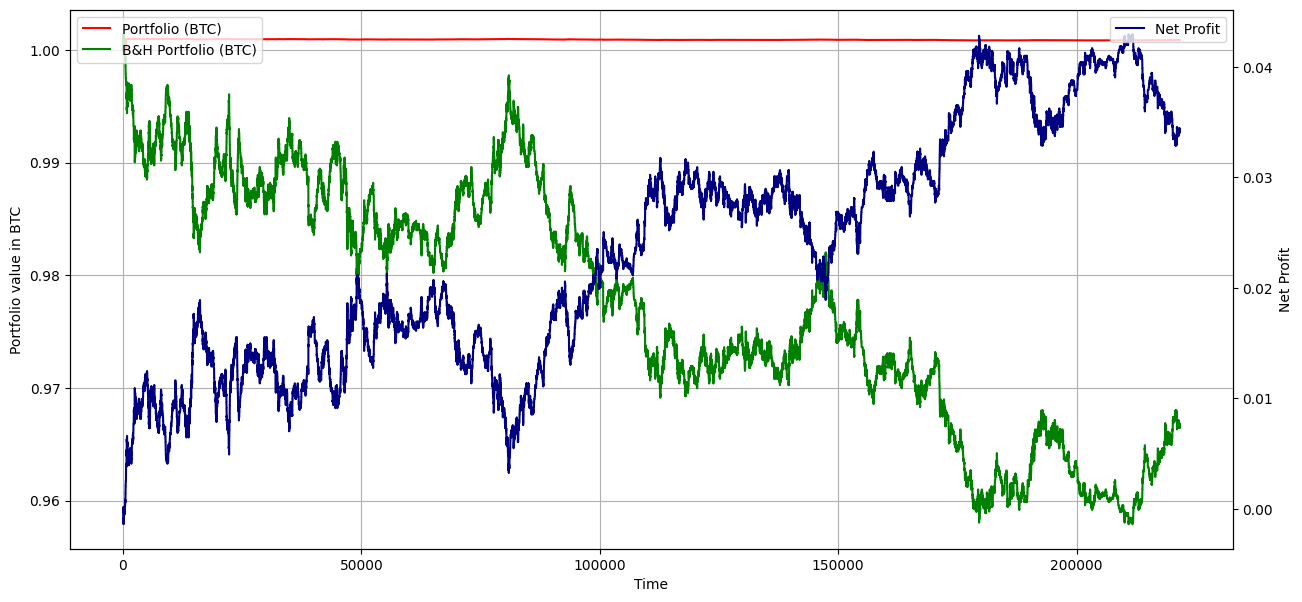

In [169]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot((1+(bal.combined + bal.combined_hedging).pct_change()).cumprod(), label='Portfolio (BTC)', color='r')
ax.plot((1+(bal.bh_BTC + bal.bh_COMP * bal.mid).pct_change()).cumprod(), label='B&H Portfolio (BTC)', color='g')

ax2 = ax.twinx()
ax2.plot((1+(bal.combined + bal.combined_hedging).pct_change()).cumprod() - (1+(bal.bh_BTC + bal.bh_COMP * bal.mid).pct_change()).cumprod(), label='Net Profit', color='navy')
#ax2.plot(bal.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Net Profit')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()

## Trade Exploration

In [187]:
from datetime import datetime

In [282]:
start =int(datetime(2023, 7, 1, 2, 30).timestamp() * 1_000_000)
end = int(datetime(2023, 7, 1, 3, 10).timestamp() * 1_000_000)

In [283]:
o_trades = pd.DataFrame(origin.trades)
h_trades = pd.DataFrame(hedging.trades)

In [277]:
binance_data.set_index('timestamp', inplace=True)
upbit_data.set_index('timestamp', inplace=True)

KeyError: "None of ['timestamp'] are in the columns"

In [278]:
pd.to_datetime(o_trades.entryTime, unit='us')

0   2023-07-01 00:00:04.562729728
1   2023-07-01 00:04:04.870941952
Name: entryTime, dtype: datetime64[ns]

In [279]:
pd.to_datetime(o_trades.eventTime, unit='us')

0   2023-07-01 00:02:43.323000064
1   2023-07-01 00:04:04.870941952
Name: eventTime, dtype: datetime64[ns]

In [280]:
pd.to_datetime(binance_data.loc[start:end,:].index, unit='us')

DatetimeIndex(['2023-07-01 00:00:04.555574', '2023-07-01 00:00:04.648000',
               '2023-07-01 00:00:04.948000', '2023-07-01 00:00:05.148000',
               '2023-07-01 00:00:07.550000', '2023-07-01 00:00:07.650000',
               '2023-07-01 00:00:07.750000', '2023-07-01 00:00:08.250000',
               '2023-07-01 00:00:08.650000', '2023-07-01 00:00:09.651000',
               ...
               '2023-07-01 00:09:34.329000', '2023-07-01 00:09:36.230000',
               '2023-07-01 00:09:37.130000', '2023-07-01 00:09:37.230000',
               '2023-07-01 00:09:40.832000', '2023-07-01 00:09:41.432000',
               '2023-07-01 00:09:41.532000', '2023-07-01 00:09:45.534000',
               '2023-07-01 00:09:48.536000', '2023-07-01 00:09:55.739000'],
              dtype='datetime64[ns]', name='timestamp', length=533, freq=None)

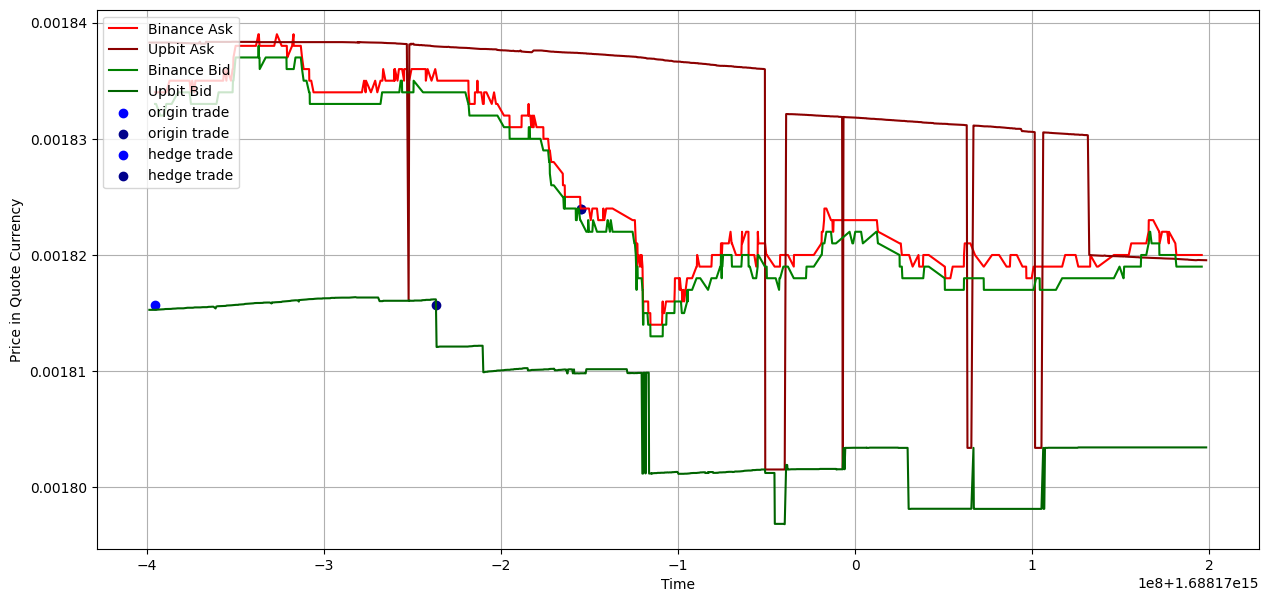

In [288]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(binance_data.loc[start:end, 'ask_price'], label='Binance Ask', color='red')
ax.plot(upbit_data.loc[start:end, 'ask_price'], label='Upbit Ask', color='darkred')
ax.plot(binance_data.loc[start:end, 'bid_price'], label='Binance Bid', color='green')
ax.plot(upbit_data.loc[start:end, 'bid_price'], label='Upbit Bid', color='darkgreen')

ax.scatter(o_trades.entryTime[0], o_trades.price[0], color='blue', label='origin trade')
ax.scatter(o_trades.eventTime[0], o_trades.price[0], color='darkblue', label='origin trade')
ax.scatter(h_trades.entryTime[0], h_trades.price[0], color='blue', label='hedge trade')
ax.scatter(h_trades.eventTime[0], h_trades.price[0], color='darkblue', label='hedge trade')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=2)
ax.grid()